### Required Libraries:
- Pandas
- Numpy
- Datetime
- Yfinance
- Scipy
- Matplotlib

In [1]:
import pandas as pd
import numpy as np
import datetime
import yfinance as yf
import scipy.stats
import matplotlib.pyplot as plt
import random
%matplotlib inline

### Getting Data

Getting Started with data of stocks from Downjones Index

In [2]:
djia_comp=(pd.read_html('https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average'))[1].Symbol.to_list()
djia_data=(yf.download(djia_comp,threads=False))['Adj Close']
djia_data=(djia_data.loc['1995':]).dropna(axis=1) 

[*********************100%***********************]  30 of 30 completed


### I. Risky assets characteristics
### 1. Basic Quantitative Analysis
- Expected Return
- Standard deviation/ Covariance/ Correlations
- Skewness/ Kurtorsis
- Maximum drawdown


In [3]:
df_returns=djia_data.pct_change().dropna() #Expected Returns
sd=df_returns.std() #standard deviation
df_m_ret = df_returns.resample('M').sum() #Get Monthly Returns

Functions to compute annualized return and volatility, given series of returns

In [6]:
def annualized_return(r,periods_per_year=252,log_return=True):
    """
    Compute annualized return, given a series of returns
    """
    total_return=(1+r).prod()
    n=r.shape[0]
    if log_return:
        annualized_return=r.mean()*periods_per_year
    else:
        annualized_return=total_return**(periods_per_year/n)-1
    return annualized_return

def annualized_volatility(r,periods_per_year=252):
    """
    Compute annualized volatility of an asset
    """
    sd=r.std() #Volatility per period
    ann_vol=sd*(periods_per_year**0.5) #Annualized Volatility
    return ann_vol

Compute Maximum drawdown

In [7]:
def maximum_drawdown(r):
    """
    Compute maximum drawdown
    """
    wealth=(1+r).cumprod()
    previous_peak=wealth.cummax()
    drawdown=wealth/previous_peak-1
    return drawdown.min()

Skewness and Kurtosis: Normal distribution has skewness and kurtosis of roughly 0 and 3 respectively

In [8]:
def skewness(r):
    """
    Compute skewness
    """
    demean=r-r.mean()
    sd=r.std(ddof=0)
    skewness=(demean**3).mean()/sd**3
    return skewness

def kurtosis(r):
    demean=r-r.mean()
    sd=r.std(ddof=0)
    kurtosis=(demean**4).mean()/sd**4
    return kurtosis
    

#### Take an example of Apple stock, ticker: AAPL
Using above function to compute annual return, volatility, skewness, kurtosis and maximum drawdown

In [11]:
# List of tickers
djia_data.columns

Index(['AAPL', 'AMGN', 'AXP', 'BA', 'CAT', 'CSCO', 'CVX', 'DIS', 'HD', 'HON',
       'IBM', 'INTC', 'JNJ', 'JPM', 'KO', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE',
       'PG', 'TRV', 'UNH', 'VZ', 'WBA', 'WMT'],
      dtype='object')

In [12]:
ticker='AAPL'
r=df_returns[ticker]
expected_return = annualized_return(r)
annual_volatility = annualized_volatility(r)
max_dd = maximum_drawdown(r)
skewness_r = skewness(r)
kurtosis_r = kurtosis(r)
print('Ticker: ',ticker)
print('Annualized return: {:.2f} %'.format(100*expected_return))
print('Annualized Volatility: {:.2f} %'.format(100*annual_volatility))
print('Max Drawdown: {:.2f} %'.format(100*max_dd))
print('Skewness: {0:.2f} \nKurtosis: {1:.2f}'.format(skewness_r,kurtosis_r))

Ticker:  AAPL
Annualized return: 32.96 %
Annualized Volatility: 43.66 %
Max Drawdown: -81.80 %
Skewness: -0.46 
Kurtosis: 29.80


#### Visualized stock price

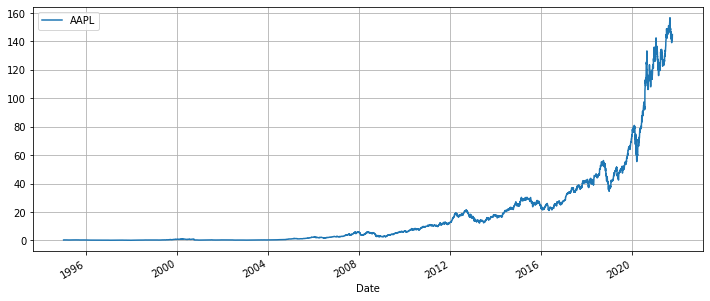

In [13]:
djia_data[ticker].plot(grid=True,figsize=(12,5),legend=True)

### 2. Value at Risk (VaR)
- Historial VaR: Non - parametric approach
- Gaussian VaR: Parametric approach
- Conditional VaR or CVaR or Expected Shortfall (ES)
- Cornish - Fisher VaR: Hybrid approach

In [14]:
def historical_var(r,level=5):
    """
    Return historical Value at Risk (VaR) at a specified level,
    default is 5 percent
    VaR is returned as an absolute value
    """
    if isinstance(r,pd.DataFrame):
        return r.aggregate(historical_var,level=level)
    elif isinstance(r,pd.Series):
        return -np.percentile(r,level)
    
from scipy.stats import norm

def guassian_var(r,level=5):
    """
    Assuming that return series are normally distributed, 
    VaR is computed, using Z - score, mean and standard deviation
    """
    z=norm.ppf(level/100)
    var = -(r.mean() + z*r.std()) #VaR takes absolute value
    return var

def cvar_historical(r,level=5):
    if isinstance(r,pd.Series):
        beyond_var_ = r <= -historical_var(r,level=level)
        return -r[beyond_var_].mean()
    elif isinstance(r, pd.DataFrame):
        return r.aggregate(cvar_historical, level=level)
    
def cornish_fisher_var(r,level=5):
    z = norm.ppf(level/100)
    s = skewness(r)
    k = kurtosis(r)
    z = (z +
            (z**2 - 1)*s/6 +
            (z**3 -3*z)*(k-3)/24 -
            (2*z**3 - 5*z)*(s**2)/36
        )
    return - (r.mean() +z*r.std())

In [15]:
print('Ticker: ', ticker)
print('Historical Value at risk (5%): {:.2f} %'.format(100*historical_var(r)))
print('Guassian Value at risk (5%): {:.2f} %'.format(100*guassian_var(r)))
print('Conditional Value at risk - CVaR/ Expected shortfall (5%): {:.2f} %'.format(100*cvar_historical(r)))
print('Cornish - Fisher Value at risk (5%): {:.2f} %'.format(100*cornish_fisher_var(r)))

Ticker:  AAPL
Historical Value at risk (5%): 3.96 %
Guassian Value at risk (5%): 4.39 %
Conditional Value at risk - CVaR/ Expected shortfall (5%): 5.99 %
Cornish - Fisher Value at risk (5%): 3.25 %


### 3. Sharpe Ratio

In [16]:
def sharpe_ratio(r,rf=0.03,n=252,log_return=True):
    """
    Compute sharpe ratio, given return series, risk-free rate (rf)
    Number of periods per year (n)
    """
    if log_return:
        rf_per_period = np.log(1+rf)/n
    else:
        rf_per_period = (1 + rf)**(1/n) - 1
    excess_ret = r - rf_per_period
    ann_excess_ret = annualized_return(excess_ret,n)
    ann_vol = annualized_volatility(r,n)
    sharpe_ratio = ann_excess_ret/ann_vol
    return sharpe_ratio

In [17]:
print(ticker,'has sharpe ratio of {:.2f}'.format(sharpe_ratio(r)))

AAPL has sharpe ratio of 0.69


### 4. Summary statistics of risky assets, all in one Function
Annualized return, volatility, skewness, kurtosis, Value at risk, Maximum drawdown and Sharpe ratio

In [18]:
def summary_stats(df,n=12,level=5):
    ann_ret = annualized_return(df,n)
    ann_vol = annualized_volatility(df,n)
    s = skewness(df)
    k = kurtosis(df)
    his_var = historical_var(df,level)
    guass_var = guassian_var(df,level)
    c_var = cvar_historical(df,level)
    sharpe_r = sharpe_ratio(df,n=n)
    max_dd = maximum_drawdown(df)
    return pd.DataFrame(data={'Annualized Return':ann_ret,'Annualized Volatility':ann_vol,'Skewness':s,
                             'Kurtosis': k,'Historical VaR (5%)': his_var, 'Guassian VaR (5%)': guass_var,
                             'Conditional VaR (5%)': c_var,'Sharpe Ratio':sharpe_r,'Max Drawdown':max_dd})
    

In [19]:
summary_statistics = summary_stats(df_m_ret,12,5)
summary_statistics.sort_values(by='Sharpe Ratio',ascending=False).head(10)

,Annualized Return,Annualized Volatility,Skewness,Kurtosis,Historical VaR (5%),Guassian VaR (5%),Conditional VaR (5%),Sharpe Ratio,Max Drawdown
UNH,0.231263,0.278266,-1.244867,7.457440,0.111381,0.112857,0.192874,0.724862,-0.659883
AAPL,0.328812,0.416986,-0.684179,6.080505,0.157941,0.170596,0.259918,0.717657,-0.818616
MSFT,0.230202,0.294144,0.038834,5.557957,0.111715,0.120484,0.162669,0.682125,-0.662753
HD,0.197544,0.248894,-0.075137,3.676800,0.097584,0.101720,0.145400,0.674926,-0.630085
NKE,0.218110,0.281711,-0.674510,7.556733,0.114019,0.115588,0.181425,0.669307,-0.624294
MCD,0.155143,0.201236,-0.571529,5.156471,0.089106,0.082624,0.127208,0.624063,-0.688438
JNJ,0.136872,0.177831,-0.118830,3.959535,0.072159,0.073033,0.105883,0.603454,-0.321388
AMGN,0.188620,0.277308,0.517458,4.578940,0.110731,0.115955,0.144496,0.573591,-0.492173
PG,0.132830,0.184493,-1.161877,11.260331,0.069200,0.076533,0.118823,0.559757,-0.489600
AXP,0.190366,0.292172,1.056713,17.404295,0.134292,0.122868,0.186638,0.550386,-0.767453


### II. Portfolio Analysis

2-asset Portfolio: Benefit of Diversification

In [20]:
assets_2 = ['JNJ','CSCO']
expected_return = annualized_return(df_returns)[assets_2]
ann_vol = annualized_volatility(df_returns)[assets_2]
cov_matrix = 252*(df_returns.cov()).loc[assets_2,assets_2]
corr_matrix = (df_returns.corr()).loc[assets_2,assets_2]

In [21]:
corr_matrix

,JNJ,CSCO
JNJ,1.000000,0.260326
CSCO,0.260326,1.000000


In [22]:
def portfolio_return(w,er):
    return w.T@er

def portfolio_volatility(w,cov):
    return (w.T@cov@w)**0.5

#### Efficient Frontier with 2 risky assets

In [23]:
weights = [np.array([w,1-w]) for w in np.linspace(0,1,20)]
returns = [portfolio_return(w,expected_return) for w in weights]
volatility = [portfolio_volatility(w,cov_matrix) for w in weights]
ef_2 = pd.DataFrame(data={'Return':returns,'Volatility':volatility})

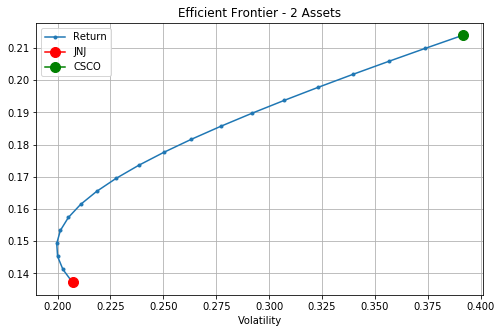

In [24]:
ax=ef_2.plot.line(x='Volatility',y='Return',style='.-',figsize=(8,5),grid=True,title='Efficient Frontier - 2 Assets')
ax.plot([ann_vol[assets_2[0]]],[expected_return[assets_2[0]]],marker='o',markersize=10,label=assets_2[0],color='r')
ax.plot([ann_vol[assets_2[1]]],[expected_return[assets_2[1]]],marker='o',markersize=10,label=assets_2[1],color='g')
ax.legend()

#### Efficient Frontier with N assets

In [25]:
from scipy.optimize import minimize

#### Steps in construction of Efficient Frontier:
- Obtain Expected Return and Covariance Matrix
- Obtain Optimal Weights: The weight at which volatility is minimize for a given level of return

In [26]:
er = annualized_return(df_returns)
cov = df_returns.cov()*252
risk_free = 0.03

In [27]:
def minimize_volatility(target_return, cov, er):
    n = cov.shape[0]
    init_guess = np.repeat(1/n,n)
    sum_to_1 = {'type':'eq',
               'fun': lambda w: np.sum(w) - 1}
    target_return_met = {'type':'eq',
                         'args':(er,),
                        'fun': lambda w,er: portfolio_return(w,er) - target_return}
    bounds = ((0.0,1.0),)*n
    result = minimize(portfolio_volatility, init_guess,
                     args=(cov,),method='SLSQP',
                     bounds=bounds,
                     constraints=(sum_to_1,target_return_met))
    return result.x

In [28]:
def optimal_weights(er,cov,n=30):
    x = np.linspace(er.min(),er.max(),n)
    weights = [minimize_volatility(r,cov,er) for r in x]
    return weights
    

Max Sharpe ratio and Global minimum variance Portfolio

In [29]:
def max_sharpe(er,cov,rf=0.03,max_w=1.0):
    n = cov.shape[0]
    init_guess = np.repeat(1/n,n)
    bounds = ((0,max_w),)*n
    def negative_sharpe(weights,er,cov,rf):
        p_return = portfolio_return(weights,er)
        p_vol = portfolio_volatility(weights,cov)
        return -(p_return - rf)/p_vol
    weights_sum_to_1 = {'type':'eq',
                       'fun': lambda w: np.sum(w) - 1}
    result = minimize(negative_sharpe, init_guess,
                     args=(er,cov,rf),method='SLSQP',
                     bounds=bounds,
                     constraints=(weights_sum_to_1))  
    return result.x

def gmv(cov,max_w=1):
    n = cov.shape[0]
    return max_sharpe(np.repeat(1,n),cov,0,max_w)
    

In [30]:
weights = optimal_weights(er,cov,25)
ret = [portfolio_return(w,er) for w in weights]
vol = [portfolio_volatility(w,cov) for w in weights]
ef_n = pd.DataFrame(data={'Return':ret,'Volatility':vol})

In [31]:
msr_w = max_sharpe(er,cov,risk_free)
msr_r = portfolio_return(msr_w,er)
msr_v = portfolio_volatility(msr_w,cov)
gmv_w = gmv(cov)
gmv_r = portfolio_return(gmv_w,er)
gmv_v = portfolio_volatility(gmv_w,cov)

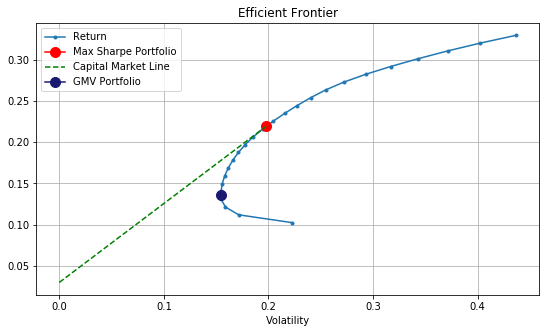

In [32]:
ax=ef_n.plot.line(x='Volatility',y='Return',style='.-',grid=True,figsize=(9,5),title='Efficient Frontier')
ax.plot([msr_v],[msr_r],color='red',marker='o',markersize=10,label='Max Sharpe Portfolio')
ax.plot([0,msr_v],[risk_free,msr_r],color='green',linestyle='--',label='Capital Market Line')
ax.plot([gmv_v],[gmv_r],color='midnightblue',marker='o',markersize=10,label='GMV Portfolio')
ax.legend()

#### Backtest different Portfolio construction techniques

Backtest uses monthly returns, rebalance every month

In [33]:
def weight_ew(r,**kwargs):
    n = r.shape[1]
    weights = pd.Series(np.repeat(1/n,n),index=r.columns)
    return weights

In [34]:
def sample_cov(r):
    return r.cov()

def cc_cov(r):
    """
    Estimation of CoVariance Matrix based on Constant correlation Model
    """
    corr_mat = r.corr()
    n = corr_mat.shape[1]
    rho_bar = (corr_mat.values.sum()-n)/(n*(n-1))
    cc = np.full_like(corr_mat,rho_bar)
    np.fill_diagonal(cc,1.0)
    sd = r.std()
    return pd.DataFrame(cc*np.outer(sd,sd),index=r.columns,columns=r.columns)

def ewm_cov(r,alpha=0.06,**kwargs):
    """
    Compute Covariance Matrix given Return Series
    
    """
    ewm_cov=r.ewm(alpha=alpha).cov()
    d=(ewm_cov.index[-1][0]).strftime('%Y-%m-%d')
    cov=(ewm_cov.loc[d,:]).values
    cov_df=pd.DataFrame(cov,index=r.columns,columns=r.columns)
    return cov_df

def shrinkage_cov(r,delta=0.5):
    prior = cc_cov(r)
    sample = sample_cov(r)
    return delta*prior + (1-delta)*sample
    

def weight_gmv(r,cov_estimator=sample_cov,max_w=1):
    cov_estimation = cov_estimator(r)
    return gmv(cov_estimation,max_w)

    

In [35]:
def risk_contribution(cov,weight):
    pvar = portfolio_volatility(weight,cov)
    return np.multiply(weight,cov@weight)/pvar

def target_risk_contribution(target_risk,cov):
    def msd(weights,target_risk,cov):
        risk_contrib = risk_contribution(cov,weights)
        return ((target_risk - risk_contrib)**2).sum()
    n = cov.shape[0]
    init_guess = np.repeat(1/n,n)
    bounds = ((0,1),)*n
    w_sum_to_1 = {'type':'eq',
                 'fun': lambda w: w.sum()-1}
    results=scipy.optimize.minimize(msd, init_guess, args=(target_risk,cov),
                           method='SLSQP',bounds=bounds, constraints=(w_sum_to_1))
    return results.x

def equal_risk_contribution(cov):
    n = cov.shape[0]
    target = np.repeat(1/n,n)
    return target_risk_contribution(target,cov)

def weight_erc(r,cov_estimator=sample_cov,**kwargs):
    cov_est = cov_estimator(r)
    return equal_risk_contribution(cov_est)

In [36]:
def backtest_ws(r,weighting=weight_ew,estimation_window=60,**kwargs):
    n = r.shape[0]
    windows = [(start, start+estimation_window) for start in range(n-estimation_window)]
    weights = [weighting(r.iloc[w[0]:w[1]],**kwargs) for w in windows]
    weights = pd.DataFrame(weights,index=(r.iloc[estimation_window:]).index,columns=r.columns)
    returns = (weights*r).sum(axis='columns',min_count=1)
    return returns

In [41]:
def horse_race(df,window=60):
    number_of_stock = df.shape[1]
    ew = backtest_ws(df,weighting=weight_ew,estimation_window=window)
    _sample_cov = backtest_ws(df,weighting=weight_gmv,estimation_window=window,cov_estimator=sample_cov)
    _cc_cov = backtest_ws(df,weight_gmv,window,cov_estimator=cc_cov)
    _shrink_cov = backtest_ws(df,weight_gmv,estimation_window=window,cov_estimator=shrinkage_cov)
    _erc = backtest_ws(df,weight_erc,estimation_window=window,cov_estimator=sample_cov)
    return pd.DataFrame({'EW':ew,'GMV - Sample Cov':_sample_cov,'GMV - Constant Correlation':_cc_cov,
                         'GMV - Shrinkage Cov': _shrink_cov,'ERC':_erc})

This process of backtesting will take several mininutes due to the optimization

In [42]:
btr1 = horse_race(df_m_ret,60)

In [43]:
summary_stats(btr1.dropna(),n=12).sort_values(by='Sharpe Ratio',ascending=False)

,Annualized Return,Annualized Volatility,Skewness,Kurtosis,Historical VaR (5%),Guassian VaR (5%),Conditional VaR (5%),Sharpe Ratio,Max Drawdown
EW,0.132319,0.142129,-0.306093,3.920740,0.064470,0.056460,0.085807,0.723006,-0.362151
GMV - Sample Cov,0.110359,0.119393,-0.539995,4.215138,0.056879,0.047494,0.076644,0.676760,-0.281051
GMV - Shrinkage Cov,0.099704,0.119407,-0.627416,4.381286,0.057058,0.048389,0.078647,0.587445,-0.270041
ERC,0.164536,0.236492,-0.089488,4.842698,0.105952,0.098582,0.149092,0.570746,-0.507840
GMV - Constant Correlation,0.095618,0.121468,-0.723654,4.346086,0.056899,0.049708,0.082132,0.543839,-0.269091


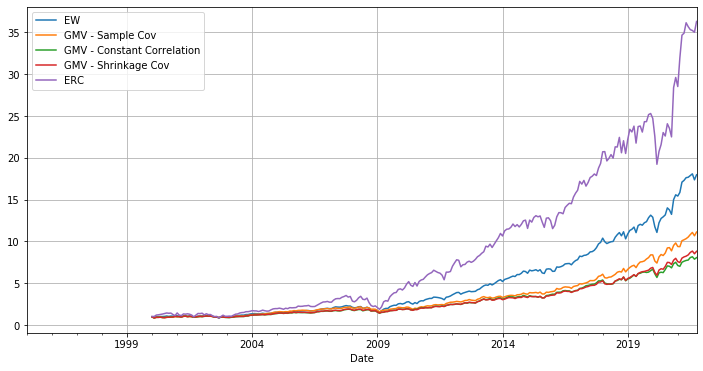

In [48]:
np.exp(btr1.cumsum()).plot(grid=True,figsize=(12,6),legend=True)